<a href="https://colab.research.google.com/github/JuanRosero775/M-todos-matem-ticos-1---Grupo-C1---Juan-Rosero---2231588/blob/main/Asignaci%C3%B3n_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Codigo Asignacion 1

Juan rosero, joham Pitre

In [ ]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# Símbolos y funcionales
# ======================
# Índices y tamaño de muestra
j, N = sp.symbols('j N', integer=True, positive=True)

# Parámetros del modelo y de promediado
alpha = sp.symbols('alpha', real=True)    # factor de calibración
W = sp.symbols('W', positive=True)        # ancho de ventana (tiempo)

# Secuencias: promedios por ventana (referencia e IoT)
f = sp.IndexedBase('f')        # f[j] ≡ promedio referencia en la ventana j
fhat = sp.IndexedBase('fhat')  # fhat[j] ≡ promedio IoT en la ventana j

# Distancia euclídea entre series promediadas
D_expr = sp.sqrt(sp.summation((f[j] - fhat[j])**2, (j, 1, N)))

# Funcional de mínimos cuadrados
S_expr = sp.summation((f[j] - alpha*fhat[j])**2, (j, 1, N))

# ======================
# Estructura de datos
# ======================
# Rutas de los archivos
REF_PATH = "https://raw.githubusercontent.com/nunezluis/MisCursos/main/MisMateriales/Asignaciones/TallerDistancias/DatosDistancias/Datos%20Estaciones%20AMB.xlsx"
IOT_PATH = "https://raw.githubusercontent.com/nunezluis/MisCursos/main/MisMateriales/Asignaciones/TallerDistancias/DatosDistancias/mediciones_clg_normalsup_pm25_a_2018-11-01T00_00_00_2018-11-30T23_59_59.csv"

LOCAL_TZ = "America/Bogota"
VAL_COL  = "pm25"

# =======================
# Carga y estandarización
# =======================

# Estandariza índice temporal y tipo numérico; deja índice datetime TZ-aware y columna 'pm25'.

def _clean_series(df, local_tz="America/Bogota"):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
    df = df[~df.index.isna()]
    df = df.sort_index()
    try:
        df = df.tz_convert(local_tz)
    except Exception:
        df = df.tz_localize(local_tz)

    df["pm25"] = pd.to_numeric(df["pm25"], errors="coerce")
    df = df.dropna(subset=["pm25"])

    return df


   # Lee el archivo de referencia AMB y lo estandariza:
   # - Toma columnas ['Date&Time', 'PM2.5']

def load_ref_series(path, local_tz="America/Bogota"):
    df = pd.read_excel(path, usecols=["Date&Time", "PM2.5"], engine="openpyxl")
    df = df.set_index("Date&Time")[["PM2.5"]].copy()
    df = df.rename(columns={'PM2.5': 'pm25'}) # Rename column to 'pm25'
    return _clean_series(df, local_tz=local_tz)


   # Lee el archivo IoT (CSV) y lo estandariza:
   # - Toma columnas ['fecha_hora_med', 'valor']

def load_iot_series(path, local_tz="America/Bogota"):
    df = pd.read_csv(path, usecols=["fecha_hora_med", "valor"])
    df = df.set_index("fecha_hora_med")[["valor"]].copy()
    df = df.rename(columns={'valor': 'pm25'}) # Rename column to 'pm25'
    return _clean_series(df, local_tz=local_tz)

In [ ]:
# ======================
#  Ventaneo y alineación
# ======================

 # Construye promedios por ventanas comunes de ancho 'win_minutes',devuelve un DataFrame con índice en el centro de cada ventana y columnas: 'f' (referencia) y 'fhat' (IoT).

def windowed_means(df_ref, df_iot, val_col=VAL_COL, win_minutes=30):
    rule = f'{win_minutes}min'
    ref_key = df_ref.index.floor(rule)
    iot_key = df_iot.index.floor(rule)

    ref_win = (df_ref
               .assign(win_start=ref_key)
               .groupby('win_start')[val_col]
               .mean()
               .to_frame('f'))
    iot_win = (df_iot
               .assign(win_start=iot_key)
               .groupby('win_start')[val_col]
               .mean()
               .to_frame('fhat'))

    aligned = ref_win.join(iot_win, how='inner')

    aligned = aligned.dropna().astype(float)
    return aligned

In [ ]:
# ====================================
#  Distancia y Error Cuadratico medio
# ====================================

  # Recibe un DataFrame con columnas 'f' y 'fhat', devuelve D (euclídea) y el Error cuadratico medio entre ambas columnas.

def distance_and_cuadraticerr(aligned_df):
    diff = aligned_df['f'] - aligned_df['fhat']
    D = np.sqrt(np.sum(np.square(diff)))
    cuadraticerr = np.sqrt(np.mean(np.square(diff))) # Corrected typo here
    N = len(aligned_df)
    return D, cuadraticerr, N

In [ ]:
# ======================
#  Alpha
# ======================
dS_dalpha = sp.diff(S_expr, alpha)
alpha_symbolic_solution = sp.Symbol('alpha_star')
alpha_solution_expr = sp.Sum(f[j]*fhat[j], (j,1,N)) / sp.Sum(fhat[j]**2, (j,1,N))

In [ ]:
# ======================
#  Estimador numérico de alpha
# ======================

# Calcula alpha* = sum(f*fhat) / sum(fhat^2) usando los promedios por ventana.
# Devuelve alpha*, y también el Error cuadratico medio del ajuste f ≈ alpha*fhat.


def fit_alpha(aligned_df):
    f_vals = aligned_df['f'].values
    h_vals = aligned_df['fhat'].values

    num = np.dot(f_vals, h_vals)
    den = np.dot(h_vals, h_vals)
    alpha_star = num / den if den != 0 else np.nan

    # RMSE del ajuste (diferente del RMSE 'crudo' f - fhat)
    pred = alpha_star * h_vals
    cuadraticerr_fit = np.sqrt(np.mean((f_vals - pred)**2))
    return alpha_star, cuadraticerr_fit

In [ ]:
# ======================
# Pipeline para las ventanas
# ======================
def evaluate_window(df_ref, df_iot, win_minutes):
    aligned = windowed_means(df_ref, df_iot, VAL_COL, win_minutes)
    D, cuadraticerr_raw, N = distance_and_cuadraticerr(aligned)
    alpha_star, cuadraticerr_fit = fit_alpha(aligned)
    out = {
        'W_min': win_minutes,
        'N_windows': N,
        'D_raw': D,
        'cuadraticerr_raw': cuadraticerr_raw,
        'alpha_star': alpha_star,
        'cuadraticerr_fit': cuadraticerr_fit,
        'aligned': aligned,
    }
    return out

In [ ]:
# Cargar y estandarizar

df_ref = load_ref_series(REF_PATH, local_tz=LOCAL_TZ)
df_iot = load_iot_series(IOT_PATH, local_tz=LOCAL_TZ)

/tmp/ipython-input-2408263478.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce", utc=True)


In [ ]:
W_SWEEP = [10, 15, 20, 30, 45, 60]

rows = []
aligned_examples = {}

for Wmin in W_SWEEP:
    res = evaluate_window(df_ref, df_iot, win_minutes=Wmin)
    rows.append({
        "W_min": Wmin,
        "N_windows": res["N_windows"],
        "cuadraticerr_raw": res["cuadraticerr_raw"],
        "alpha_star": res["alpha_star"],
        "cuadraticerr_fit": res["cuadraticerr_fit"],
    })
    aligned_examples[Wmin] = res["aligned"]

results_df = pd.DataFrame(rows).sort_values("W_min")
display(results_df)

,W_min,N_windows,cuadraticerr_raw,alpha_star,cuadraticerr_fit
0,10,136,6.431119,0.656924,4.696535
1,15,137,6.281412,0.665400,4.618873
2,20,138,6.303331,0.663080,4.617393
3,30,141,6.317478,0.660355,4.582270
4,45,143,6.281477,0.666360,4.618663
5,60,143,6.237432,0.668715,4.598528


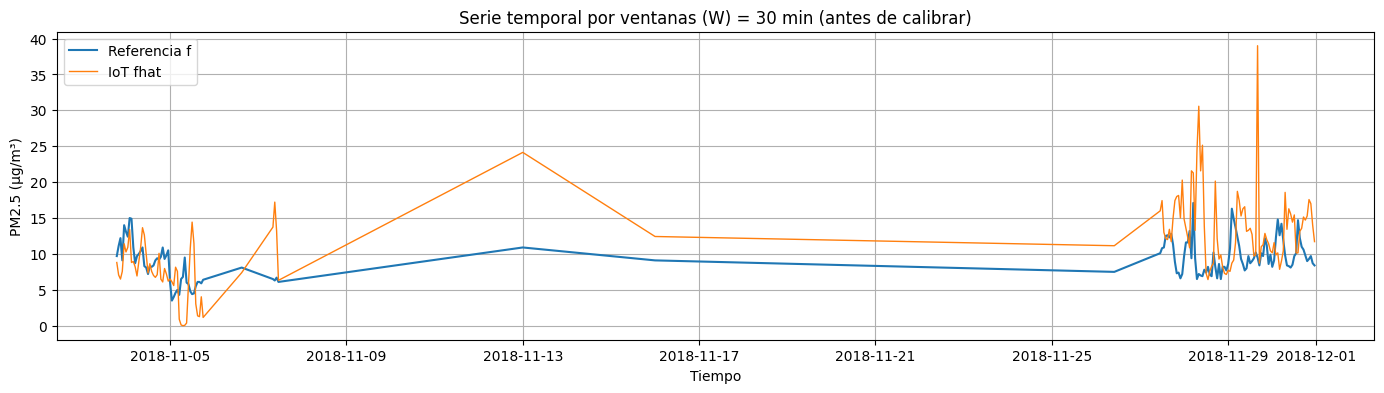

In [ ]:
# W a graficar
W_to_plot = best_W if 'best_W' in globals() and best_W in aligned_examples else 30

# Pares de f/fhat
aligned_plot = aligned_examples[W_to_plot]

# Serie de tiempo
plt.figure(figsize=(17,4))
plt.plot(aligned_plot.index, aligned_plot["f"],    lw=1.5, label="Referencia f")
plt.plot(aligned_plot.index, aligned_plot["fhat"], lw=1.0, label="IoT fhat")
plt.title(f"Serie temporal por ventanas (W) = {W_to_plot} min (antes de calibrar)")
plt.xlabel("Tiempo")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  Distancia euclídea y Error cuadratico medio para el W elegido

# Toma el W con menor cuadraticerr_fit (calculado arriba)
best_row = results_df.loc[results_df["cuadraticerr_fit"].idxmin()]
best_W   = int(best_row["W_min"])

#  Reconstruir los pares f, fhat del W elegido
aligned_best = aligned_examples[best_W]

# Distancia euclídea y Error cuadratico medio sin calibrar
D_best, cuadraticerr_best_raw, N_best = distance_and_cuadraticerr(aligned_best)

print("=== Distancia euclídea y Error cuadratico medio sin calibrar ===")
print(f"W óptimo: {best_W} min | N ventanas: {N_best}")
print(f"Distancia euclídea (D) = {D_best:.4f}")
print(f"Error cuadratico medio = {cuadraticerr_best_raw:.4f} µg/m³")

=== Distancia euclídea y Error cuadratico medio sin calibrar ===
W óptimo: 30 min | N ventanas: 141
Distancia euclídea (D) = 75.0159
Error cuadratico medio = 6.3175 µg/m³



=== Calibración por mínimos cuadrados ===
alpha* = 0.660355
Error cuadrático medio post-ajuste = 4.5823 µg/m³


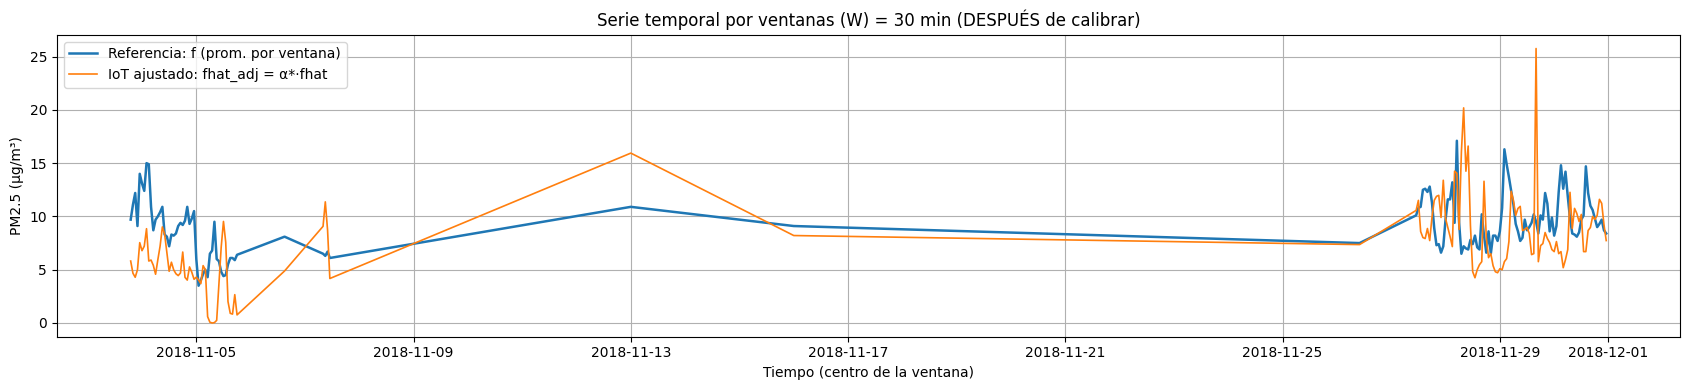

In [ ]:
alpha_star, cuadraticerr_fit = fit_alpha(aligned_best)

print("\n=== Calibración por mínimos cuadrados ===")
print(f"alpha* = {alpha_star:.6f}")
print(f"Error cuadrático medio post-ajuste = {cuadraticerr_fit:.4f} µg/m³")

# Serie ajustada del IoT por ventana: fhat_adj = alpha* * fhat
aligned_best = aligned_best.copy()
aligned_best["fhat_adj"] = alpha_star * aligned_best["fhat"]

# Gráfica con fhat ajustado
plt.figure(figsize=(17,4))
plt.plot(aligned_best.index, aligned_best["f"],        lw=1.8, label="Referencia: f (prom. por ventana)")
plt.plot(aligned_best.index, aligned_best["fhat_adj"], lw=1.2, label="IoT ajustado: fhat_adj = α*·fhat")
plt.title(f"Serie temporal por ventanas (W) = {best_W} min (DESPUÉS de calibrar)")
plt.xlabel("Tiempo (centro de la ventana)")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# === Alcance y validez con tolerancia ===

#  Parámetros de tolerancia
tolerance_abs = 5.0     # En µg/m³
use_relative_tol = False
tolerance_rel = 0.20    # 20%

# Split temporal: primera mitad (train), segunda mitad (test)
mid = int(len(aligned_best) * 0.5)
train = aligned_best.iloc[:mid].copy()
test  = aligned_best.iloc[mid:].copy()

# Ajuste en train
alpha_star, cuadraticerr_fit_train = fit_alpha(train)

# Predicción en test y errores
f_test   = test['f'].to_numpy(float)
h_test   = test['fhat'].to_numpy(float)
pred_test = alpha_star * h_test
err_abs  = np.abs(f_test - pred_test)

if use_relative_tol:
    # Evita división por cero: si f_test ~ 0, usa un epsilon o pasa a absoluta
    eps = 1e-9
    err_rel = err_abs / np.maximum(np.abs(f_test), eps)
    ok_mask = (err_rel <= tolerance_rel)
else:
    ok_mask = (err_abs <= tolerance_abs)

coverage = 100.0 * ok_mask.mean() if len(ok_mask) > 0 else np.nan

# Rango de validez en términos de fhat (IoT) dentro de tolerancia
if ok_mask.any():
    valid_fhat = h_test[ok_mask]
    valid_range = (float(np.min(valid_fhat)), float(np.max(valid_fhat)))
else:
    valid_range = (np.nan, np.nan)

print("=== Alcance y validez del modelo lineal ===")
print(f"W óptimo: {best_W} min | α* (train) = {alpha_star:.4f} | cuadraticerr_fit(train) = {cuadraticerr_fit_train:.4f} µg/m³")
if use_relative_tol:
    print(f"Tolerancia RELATIVA = {tolerance_rel*100:.1f}%")
else:
    print(f"Tolerancia ABSOLUTA = {tolerance_abs:.2f} µg/m³")

print(f"Cobertura en TEST (%% puntos dentro de tolerancia): {coverage:.1f}%")
print(f"Rango de VALIDEZ en IoT (fhat) donde se cumple la tolerancia: {valid_range[0]:.3f} → {valid_range[1]:.3f} (µg/m³)")

=== Alcance y validez del modelo lineal ===
W óptimo: 30 min | α* (train) = 0.7434 | cuadraticerr_fit(train) = 4.2982 µg/m³
Tolerancia ABSOLUTA = 5.00 µg/m³
Cobertura en TEST (%% puntos dentro de tolerancia): 77.5%
Rango de VALIDEZ en IoT (fhat) donde se cumple la tolerancia: 6.429 → 21.286 (µg/m³)


In [ ]:
# === Mínimo conjunto de datos y máximo alcance ===

# Re-arma el aligned entero para un W óptimo
aligned = aligned_best

# Parámetros
tolerance_abs   = 5.0     # µg/m³
coverage_target = 0.80    # Puntos de tolerancia
min_train       = max(10, int(0.1*len(aligned)))  # Como mínimo 10 ventanas o 10% del total
test_block      = max(10, int(0.2*len(aligned)))  # Tamaño de test fijo

best_Ntrain = None
best_alpha  = None
best_cov    = None

# Bucle: crecer entrenamiento y validar en bloque fijo
for N_train in range(min_train, len(aligned) - test_block + 1):
    train = aligned.iloc[:N_train]
    test  = aligned.iloc[N_train:N_train + test_block]

    # Ajuste
    a, _ = fit_alpha(train)
    # Predicción en test
    f_test = test['f'].to_numpy(float)
    h_test = test['fhat'].to_numpy(float)
    err_abs = np.abs(f_test - a*h_test)

    cov = np.mean(err_abs <= tolerance_abs)

    if cov >= coverage_target:
        best_Ntrain = N_train
        best_alpha  = a
        best_cov    = cov
        break

print("=== Mínimo conjunto de datos para cumplir tolerancia en test ===")
if best_Ntrain is None:
    print("No se alcanzó la cobertura objetivo con los parámetros actuales.")
else:
    print(f"N_train mínimo = {best_Ntrain} ventanas | cobertura en test = {best_cov*100:.1f}% | α* = {best_alpha:.4f}")

#  Máximo alcance
print("\n=== Máximo alcance (continuo) bajo tolerancia ===")
if best_Ntrain is not None:
    train = aligned.iloc[:best_Ntrain]
    a, _  = fit_alpha(train)

    future = aligned.iloc[best_Ntrain:]
    f_fut  = future['f'].to_numpy(float)
    h_fut  = future['fhat'].to_numpy(float)
    err_fut = np.abs(f_fut - a*h_fut)

    ok = (err_fut <= tolerance_abs)

    horizon = 0
    for flag in ok:
        if flag:
            horizon += 1
        else:
            break

    # Traduce a tiempo
    approx_minutes = horizon * best_W

    print(f"Horizonte continuo de predicción (ventanas): {horizon} ventanas ≈ {approx_minutes} min")
    if horizon > 0:
        # rango temporal exacto
        start_time = future.index[0]
        end_time   = future.index[min(horizon-1, len(future.index)-1)]
        print(f"Rango temporal cubierto: {start_time} → {end_time}")
else:
    print("No hay N_train mínimo; ajusta tolerancia o cobertura objetivo y reintenta.")

=== Mínimo conjunto de datos para cumplir tolerancia en test ===
N_train mínimo = 80 ventanas | cobertura en test = 85.7% | α* = 0.6404

=== Máximo alcance (continuo) bajo tolerancia ===
Horizonte continuo de predicción (ventanas): 14 ventanas ≈ 420 min
Rango temporal cubierto: 2018-11-28 11:00:00-05:00 → 2018-11-29 00:00:00-05:00
